# MACHINE LEARNING OLS

In [227]:
#Importing libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy import stats
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge


In [228]:
#Importing data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)
csv_file_path = '../Modeldata/data_ready_udenkom.csv'
df_final = pd.read_csv(csv_file_path)
df_final
df_final.set_index('Unnamed: 0', inplace=True)
df_final.index.name = None
print(len(df_final))

19848


In [229]:
##Deleting observations with less than 20 m2 -> To avoid "non-appartments"
outliers_m2 = df_final[(df_final['m2'] < 20) | ((df_final['m2'] < 50) & (df_final['Boligtype_Landejendom'] == 1))]

#Square meter price:
df_final['price/m2'] = df_final['Price']/df_final['m2']

print(len(df_final))
########################################################################
# Calculate Z-scores for each value in the column
df_final['z_score_price_m2'] = stats.zscore(df_final['price/m2'])

# Define outliers as any points with a Z-score > 4 or < -4
outliers_price_m2 = df_final[(df_final['z_score_price_m2'] > 3) | (df_final['z_score_price_m2'] < -3)]
#print(outliers.sort_values(by='price/m2', ascending=False))

df_final.drop(columns='price/m2', inplace=True)
########################################################################
# Calculate Z-scores for m2
df_final['z_score_m2'] = stats.zscore(df_final['m2'])

# Define outliers as any points with a Z-score > 4 or < -4
outliers_m2_z = df_final[(df_final['z_score_m2'] > 3) | (df_final['z_score_m2'] < -3)]
#print(outliers_m2.sort_values(by='m2', ascending=True))

########################################################################

#Calculate Z-scores for price
df_final['z_score_price'] = stats.zscore(df_final['Price'])
# Define outliers as any points with a Z-score > 4 or < -4
outliers_price = df_final[(df_final['z_score_price'] > 3) | (df_final['z_score_price'] < -3)]
#print(outliers_m2.sort_values(by='m2', ascending=True))

######################################################################

# Dropping all outliers at once
outliers_combined = pd.concat([outliers_m2, outliers_price_m2, outliers_m2_z, outliers_price])
df_final = df_final.drop(outliers_combined.index)

df_final = df_final.drop('z_score_m2', axis=1)
df_final = df_final.drop('z_score_price_m2', axis=1)
df_final = df_final.drop('z_score_price', axis=1)

print(len(df_final))


19848
19216


In [230]:
y = df_final['Price']
X = df_final.drop(columns=['Price'])

In [231]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=42) #The random_state works as a seed

#2
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

# OLS, Poly-degree=1

In [233]:
# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(degree=1), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

LinReg_MSE 1843391171614.35
LinReg_MAE 933749.34
LinReg_MAPE 0.81
LinReg_RMSE 1357715.4236489888
LinReg_r2 0.642651513585575


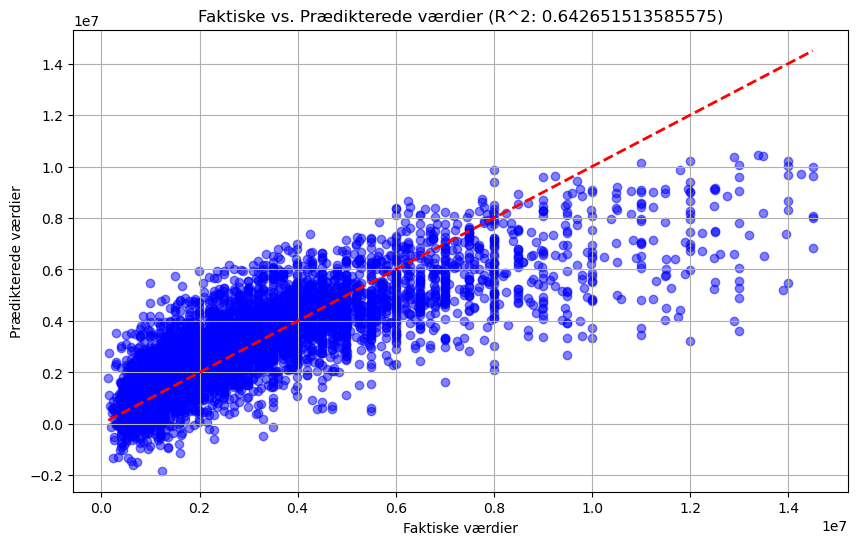

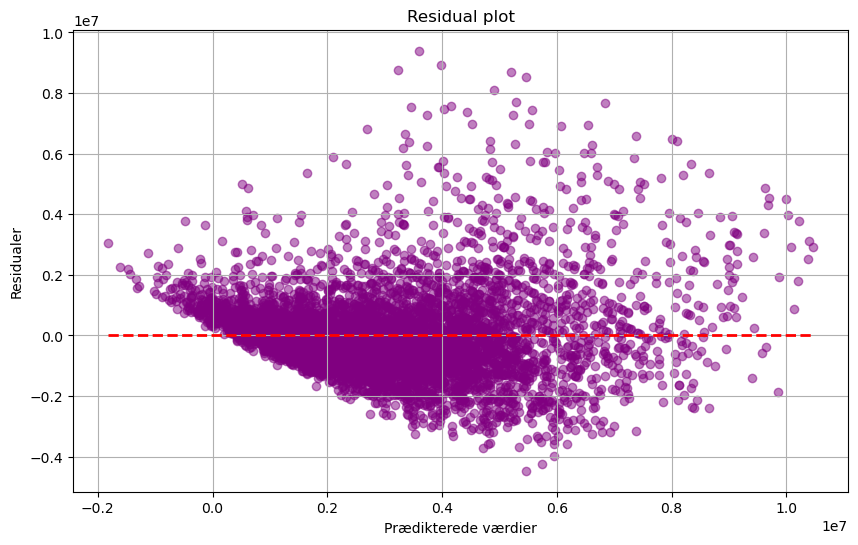

LinReg_r2 0.6529072083685199


In [234]:
y_predict_lr_degree_1 = pipe_lr.predict(X_test)
print('LinReg_MSE', round(mse(y_predict_lr_degree_1,y_test), 2))
print('LinReg_MAE', round(mean_absolute_error(y_predict_lr_degree_1, y_test), 2))
print('LinReg_MAPE', round(mean_absolute_percentage_error(y_predict_lr_degree_1, y_test), 2))
print('LinReg_RMSE', np.sqrt(mse(y_predict_lr_degree_1, y_test)))
print('LinReg_r2', r2_score(y_test, y_predict_lr_degree_1))
linear_model = pipe_lr.named_steps['linearregression']
coeff = linear_model.coef_

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict_lr_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_predict_lr_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_predict_lr_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_predict_lr_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_predict_lr_degree_1.min(), y_predict_lr_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

y_predict_lr = pipe_lr.predict(X_dev)
print('LinReg_r2', r2_score(y_dev, y_predict_lr))


# OLS, Poly-degree = 2

In [236]:
# Initializing Linear-regression-model with degree=2
from sklearn.linear_model import Lasso, LinearRegression

# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(degree=2), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

LinReg_MSE 5.099202852274224e+31
LinReg_MAE 246964419263522.84
LinReg_MAPE 0.59
LinReg_RMSE 7140870291690099.0
LinReg_r2 -9.885001345560984e+18


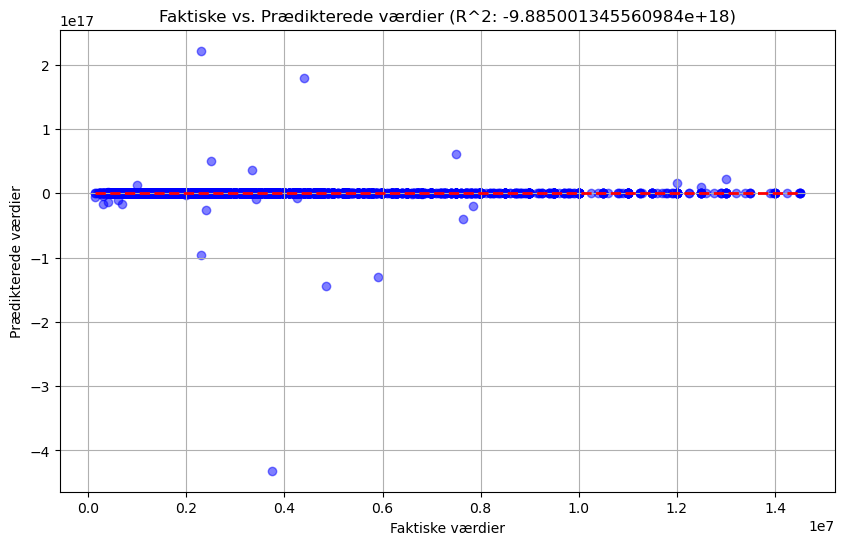

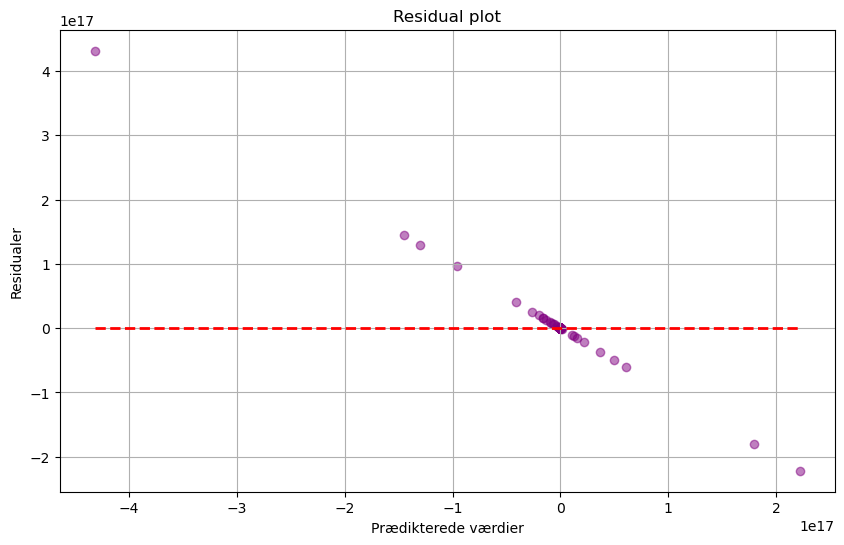

LinReg_r2 0.8380626330515913


In [237]:
y_predict_lr_degree_2 = pipe_lr.predict(X_test)
print('LinReg_MSE', round(mse(y_predict_lr_degree_2,y_test), 2))
print('LinReg_MAE', round(mean_absolute_error(y_predict_lr_degree_2, y_test), 2))
print('LinReg_MAPE', round(mean_absolute_percentage_error(y_predict_lr_degree_2, y_test), 2))
print('LinReg_RMSE', np.sqrt(mse(y_predict_lr_degree_2, y_test)))
print('LinReg_r2', r2_score(y_test, y_predict_lr_degree_2))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict_lr_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_predict_lr_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_predict_lr_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_predict_lr_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_predict_lr_degree_2.min(), y_predict_lr_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

y_predict_lr = pipe_lr.predict(X_dev)
print('LinReg_r2', r2_score(y_dev, y_predict_lr))

# Lasso-model, degree=1 and no Cross-validation

In [239]:
# Initialize Lasso-model with degree=1, CV=0
from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=42))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 2180.025323490052
Validation MSE: 1857898312131.245


In [240]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=2180.025323490052))])

Lasso_MSE_de1 1843079132767.75
Lasso_MAE_de1 931900.25
Lasso_MAPE_de1 1.02
Lasso_RMSE_de1 1357600.5055861431
Lasso_R2_de1 0.6427120035191567


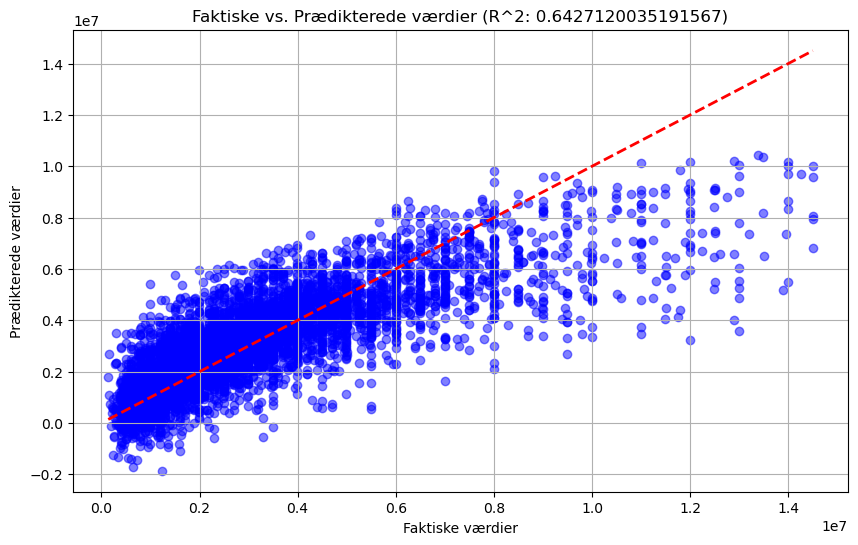

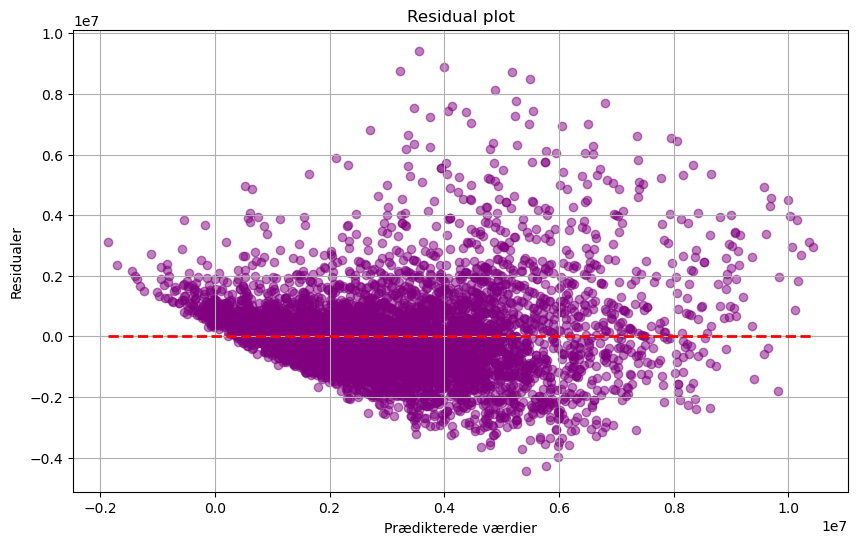

In [241]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_1 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de1', round(mse(y_test_pred_lasso_degree_1,y_test), 2))
print('Lasso_MAE_de1', round(mean_absolute_error(y_test_pred_lasso_degree_1, y_test), 2))
print('Lasso_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1, y_test), 2))
print('Lasso_RMSE_de1', np.sqrt(mse(y_test_pred_lasso_degree_1, y_test)))
print('Lasso_R2_de1', r2_score(y_test, y_test_pred_lasso_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_1.min(), y_test_pred_lasso_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# LASSO-MODEL MED DEGREE=2 and no Cross-validation

In [243]:
# Initialize Lasso-model with degree=2, CV=0
from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=42))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 70170.38286703837
Validation MSE: 1660229202977.855


In [244]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=70170.38286703837))])

Lasso_MSE_de2 1650136447857.08
Lasso_MAE_de2 869368.2
Lasso_MAPE_de2 0.51
Lasso_RMSE_de2 1284576.3690248567
Lasso_R2_de2 0.6801146869426542


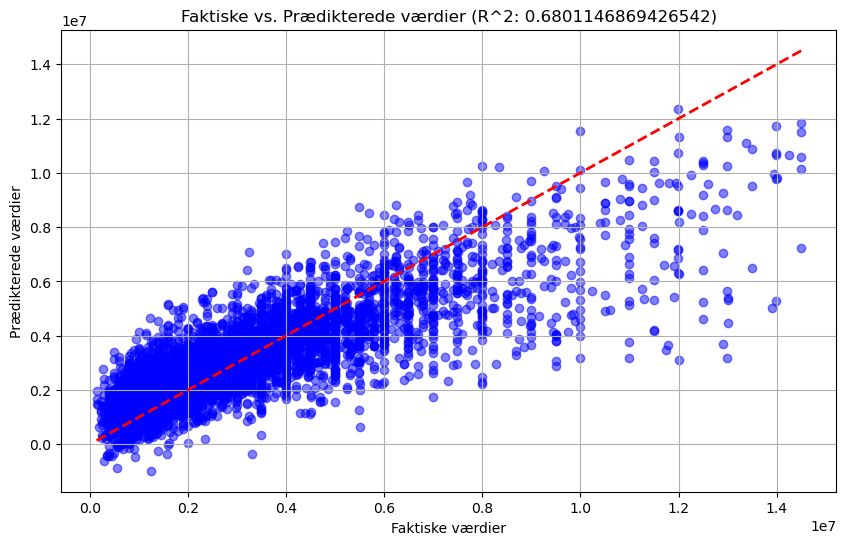

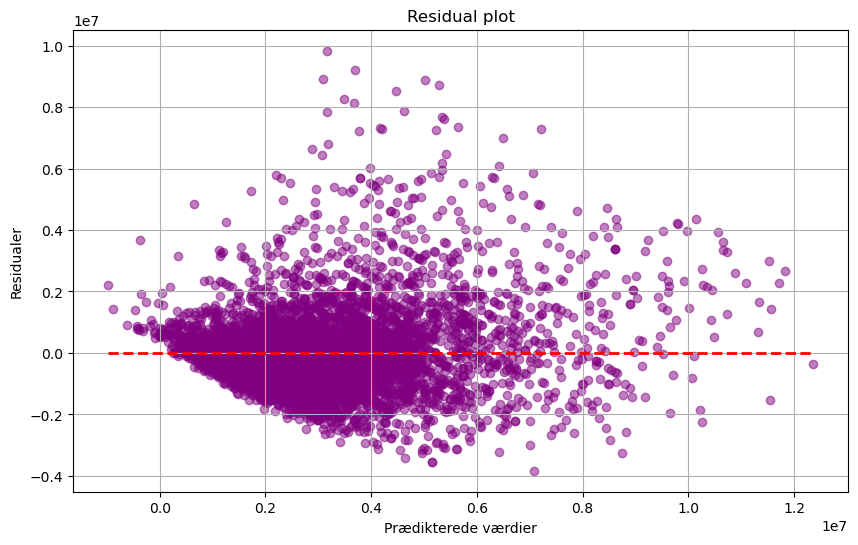

In [245]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_2 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de2', round(mse(y_test_pred_lasso_degree_2,y_test), 2))
print('Lasso_MAE_de2', round(mean_absolute_error(y_test_pred_lasso_degree_2, y_test), 2))
print('Lasso_MAPE_de2', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2, y_test), 2))
print('Lasso_RMSE_de2', np.sqrt(mse(y_test_pred_lasso_degree_2, y_test)))
print('Lasso_R2_de2', r2_score(y_test, y_test_pred_lasso_degree_2))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_2.min(), y_test_pred_lasso_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import validation_curve

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     )

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

# Lasso, Poly-degree = 1, CV = 5

Optimal lambda: 1788.649529057435
Validation MSE: 1890733106611.637


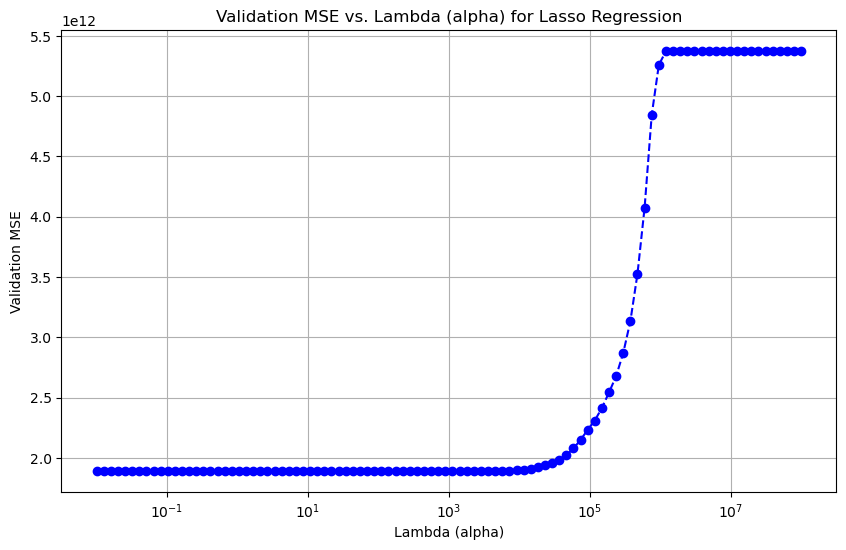

In [247]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                                   StandardScaler(),
                                   Lasso(alpha=lambda_, random_state=42))
        pipe_lasso.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_lasso.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Lasso Regression')
plt.grid(True)
plt.show()

In [248]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=1788.649529057435))])

Lasso_MSE_de1_cv_5 1842946258977.51
Lasso_MAE_de1_cv_5 932168.04
Lasso_MAPE_de1_cv_5 1.04
Lasso_RMSE_de1_cv_5 1357551.567704709
Lasso_R2_de1_cv_5 0.6427377616157326


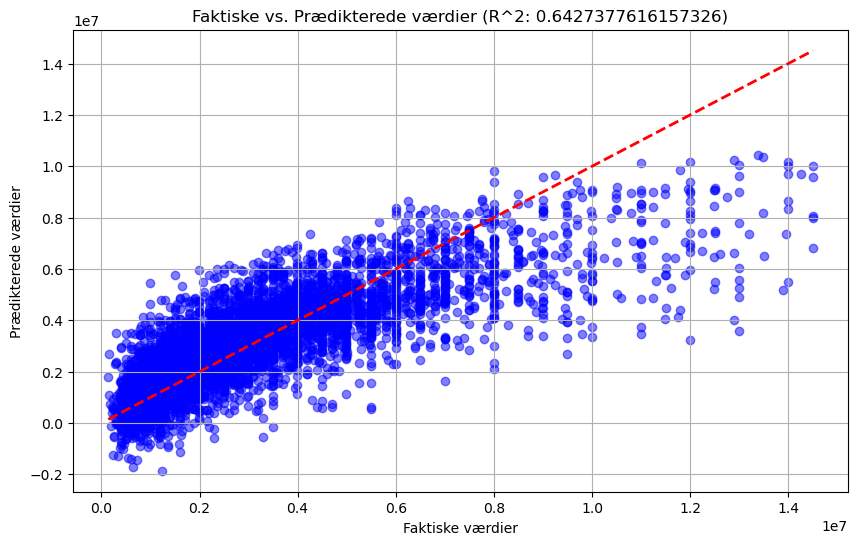

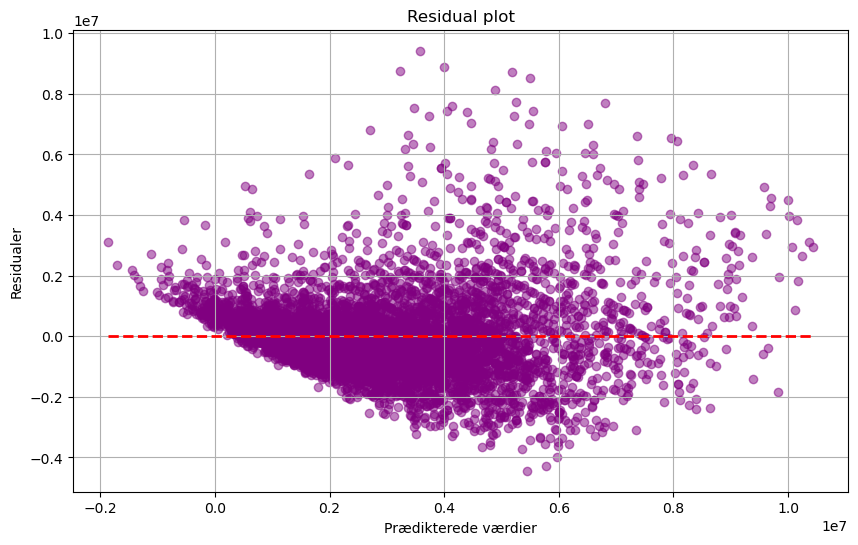

In [249]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_1_cv_5 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de1_cv_5', round(mse(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_MAE_de1_cv_5', round(mean_absolute_error(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_MAPE_de1_cv_5', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_1_cv_5, y_test)))
print('Lasso_R2_de1_cv_5', r2_score(y_test, y_test_pred_lasso_degree_1_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_1_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_1_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_1_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_1_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_1_cv_5.min(), y_test_pred_lasso_degree_1_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# LASSO, poly-degree=2, CV=5

In [251]:
"""
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                                   StandardScaler(),
                                   Lasso(alpha=lambda_, random_state=42))
        pipe_lasso.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_lasso.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Lasso Regression')
plt.grid(True)
plt.show()
"""

"\n# PREPARATION\nlambdas = np.logspace(-2, 8, 100)  # Grid of lambdas\nkf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation\n\n# Store performance for each alpha\nperform = []\n\n# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION\nfor lambda_ in lambdas:\n    fold_mse = []\n    \n    for train_index, val_index in kf.split(X_dev):\n        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]\n        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]\n\n        # Initialize and fit the Ridge model within the pipeline\n        pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), \n                                   StandardScaler(),\n                                   Lasso(alpha=lambda_, random_state=42))\n        pipe_lasso.fit(X_train_fold, y_train_fold)\n        \n        # Predict on the validation fold\n        y_pred_fold = pipe_lasso.predict(X_val_fold)\n        \n        # Calculate MSE for this fold an

In [252]:
"""
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 
"""

'\n# INSERT OPTIMAL LAMBDA INTO NEW MODEL\npipe_lasso = make_pipeline(PolynomialFeatures(degree=2), \n                           StandardScaler(),\n                           Lasso(alpha=optimal.index[0]))\n\n# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL\npipe_lasso.fit(X_dev, y_dev) \n'

In [253]:
"""
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_2_cv_5 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de2_cv_5', round(mse(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_MAE_de2_cv_5', round(mean_absolute_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_MAPE_de2_cv_5', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_2_cv_5, y_test)))
print('Lasso_R2_de2_cv_5', r2_score(y_test, y_test_pred_lasso_degree_2_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_2_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_2_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_2_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_2_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_2_cv_5.min(), y_test_pred_lasso_degree_2_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()
"""

"\n# Printing MSE, MAE, MAPE, RMSE\ny_test_pred_lasso_degree_2_cv_5 = pipe_lasso.predict(X_test)\nprint('Lasso_MSE_de2_cv_5', round(mse(y_test_pred_lasso_degree_2_cv_5, y_test), 2))\nprint('Lasso_MAE_de2_cv_5', round(mean_absolute_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))\nprint('Lasso_MAPE_de2_cv_5', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))\nprint('Lasso_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_2_cv_5, y_test)))\nprint('Lasso_R2_de2_cv_5', r2_score(y_test, y_test_pred_lasso_degree_2_cv_5))\n\n\n# Plot af faktiske vs. prædikterede værdier\nplt.figure(figsize=(10, 6))\nplt.scatter(y_test, y_test_pred_lasso_degree_2_cv_5, color='blue', alpha=0.5)\nplt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion\nplt.xlabel('Faktiske værdier')\nplt.ylabel('Prædikterede værdier')\nplt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_tes

# RIDGE MODEL, degree = 1, CV=0

Optimal lambda: 16.68100537200059
Validation MSE: 1857871555875.610


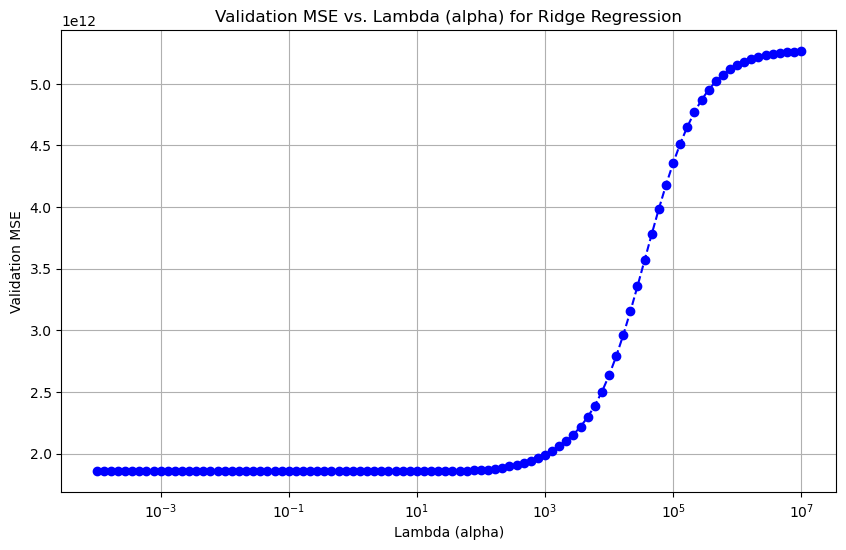

In [255]:
#Initialize the Ridge-model with degree = 1 and cv = 0
# Initialize Lasso-model with degree=2, CV=0

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-4, 7, 100) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=42))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()



In [256]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=16.68100537200059))])

Ridge_MSE_de1 1843853678907.16
Ridge_MAE_de1 933338.15
Ridge_MAPE_de1 0.91
Ridge_RMSE_de1 1357885.7385314698
Ridge_R2_de1 0.6425618547635175


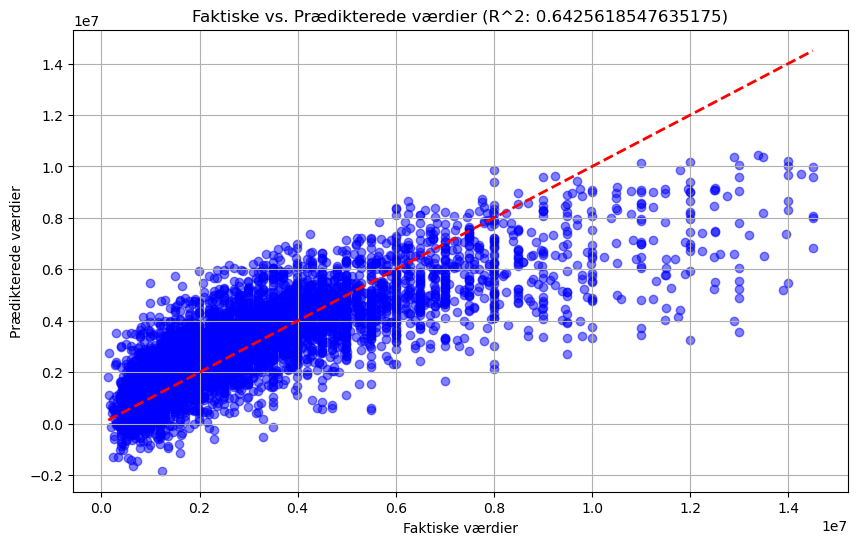

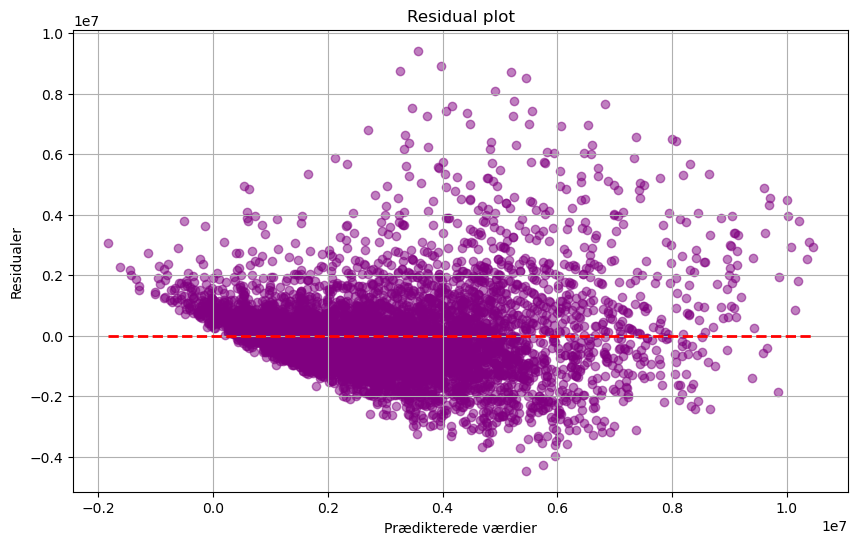

[5008614.80472717 3937151.02183169 4312898.43987056 ... 3653930.37405575
 4140838.0877254  3627723.06877055]


In [257]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_1 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de1', round(mse(y_test_pred_ridge_degree_1,y_test), 2))
print('Ridge_MAE_de1', round(mean_absolute_error(y_test_pred_ridge_degree_1, y_test), 2))
print('Ridge_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1, y_test), 2))
print('Ridge_RMSE_de1', np.sqrt(mse(y_test_pred_ridge_degree_1, y_test)))
print('Ridge_R2_de1', r2_score(y_test, y_test_pred_ridge_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_1.min(), y_test_pred_ridge_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

print(y_test_pred_ridge_degree_1)

In [258]:
# Access the Ridge model coefficients after fitting
ridge_model = pipe_ridge.named_steps['ridge']
coefficients = ridge_model.coef_

# Get feature names from PolynomialFeatures
feature_names = pipe_ridge.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)

# Combine feature names with coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coefficients_df['Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df.sort_values(by='Coefficient',ascending=False)

,Feature,Coefficient
24,anmeldelser pr 1000,1.597743e+06
25,sigtelser pr 1000,9.247818e+05
6,m2,7.817673e+05
15,Familiernes gennemsnitlige indkomst indkomst,6.646766e+05
19,andel_ikke_vestlig_opr,3.413915e+05
50,Energy-classification_ A2015,3.258817e+05
23,Karakter,3.131763e+05
43,Boligtype_Ejerlejlighed,2.876216e+05
7,Grund,2.738637e+05
21,Antal_laeger,2.680804e+05


# RIDGE, degree=2, CV=0

Optimal lambda: 23101.29700083158
Validation MSE: 1993134532760.803


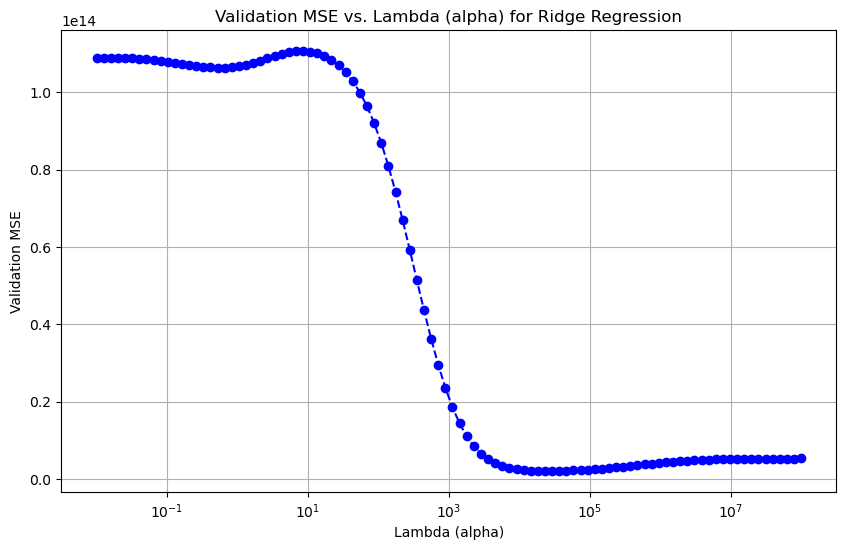

In [260]:
#Initialize the Ridge-model with degree = 1 and cv = 0
# Initialize Lasso-model with degree=2, CV=0

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-2, 8, 100) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=42))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()





In [261]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=23101.29700083158))])

Ridge_MSE_de2 1854639894445.48
Ridge_MAE_de2 868349.4
Ridge_MAPE_de2 0.38
Ridge_RMSE_de2 1361851.6418631934
Ridge_R2_de2 0.6404709052916358


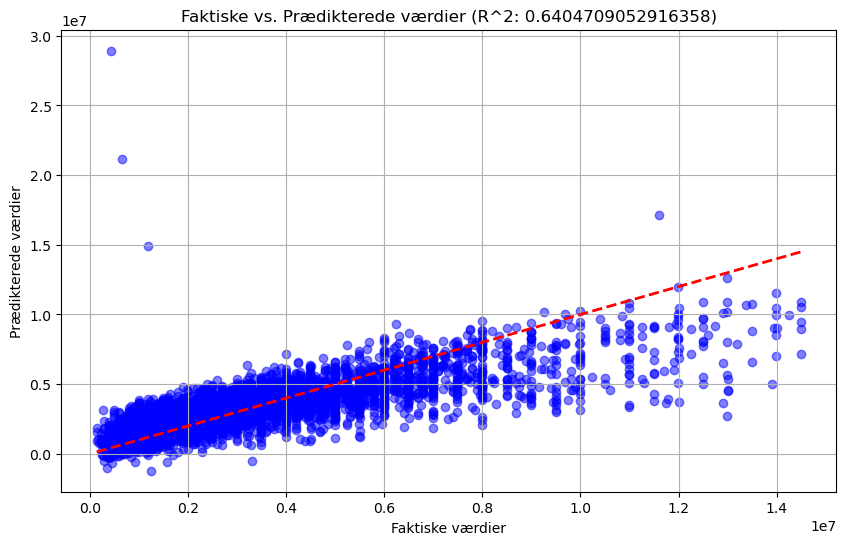

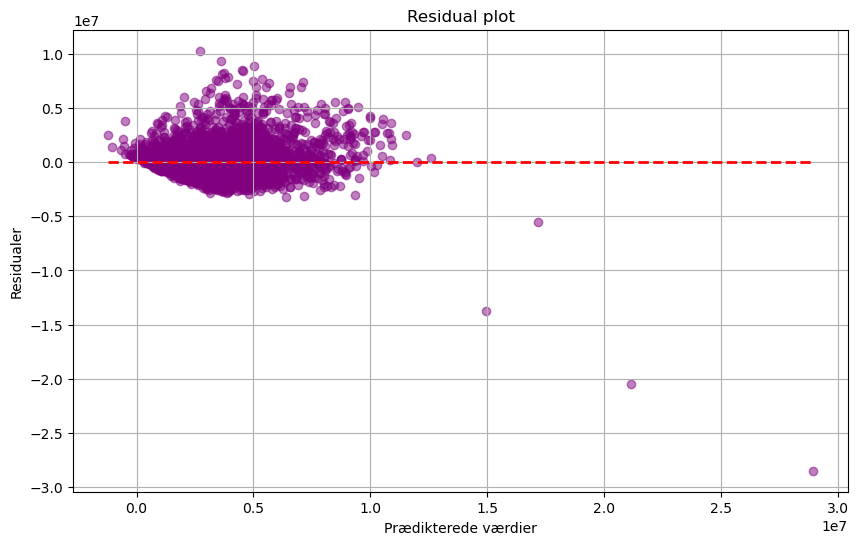

[4670152.46223205 4440964.40235237 3573428.85557526 ... 3889159.00753996
 3642863.968502   3314973.23577231]


In [262]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_2 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de2', round(mse(y_test_pred_ridge_degree_2,y_test), 2))
print('Ridge_MAE_de2', round(mean_absolute_error(y_test_pred_ridge_degree_2, y_test), 2))
print('Ridge_MAPE_de2', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2, y_test), 2))
print('Ridge_RMSE_de2', np.sqrt(mse(y_test_pred_ridge_degree_2, y_test)))
print('Ridge_R2_de2', r2_score(y_test, y_test_pred_ridge_degree_2))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_2.min(), y_test_pred_ridge_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

print(y_test_pred_ridge_degree_2)

In [263]:
# Access the Ridge model coefficients after fitting
ridge_model = pipe_ridge.named_steps['ridge']
coefficients = ridge_model.coef_

# Get feature names from PolynomialFeatures
feature_names = pipe_ridge.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)

# Combine feature names with coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coefficients_df.sort_values(by='Coefficient', ascending=True)

,Feature,Coefficient
1870,Whisky Boligtype_Ejerlejlighed,-54701.384155
1115,Gennemsnitlig_pendligafstand sigtelser pr 1000,-50630.225965
929,"m2 parker, sportsanlæg og rekreative omr pr indbygger sigtelser pr 1000",-29210.901014
556,"Rooms m2 parker, sportsanlæg og rekreative omr pr indbygger",-27736.978220
1019,andel_vestlig_opr Gennemsnitlig_pendligafstand,-27406.816124
...,...,...
878,Familiernes gennemsnitlige indkomst indkomst Karakter,56453.610952
392,m2 Karakter,58009.446588
388,m2 andel_ikke_vestlig_opr,74603.225414
384,m2 Familiernes gennemsnitlige indkomst indkomst,75398.902370


# Ridge, polynomial-features = 1, CV=5

Optimal lambda: 5.336699231206307
Validation MSE: 1891444971298.635


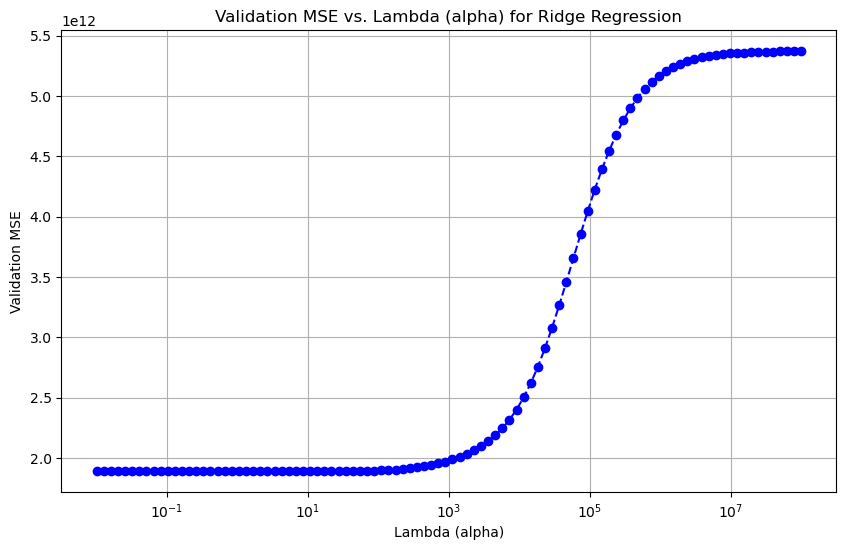

In [265]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                                   StandardScaler(),
                                   Ridge(alpha=lambda_, random_state=42))
        pipe_ridge.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_ridge.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()

In [266]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=5.336699231206307))])

Ridge_MSE_de1_cv_5 1843508619293.52
Ridge_MAE_de1_cv_5 933607.77
Ridge_MAPE_de1_cv_5 2.24
Ridge_RMSE_de1_cv_5 1357758.6749100587
Ridge_R2_de1_cv_5 0.642628745900111


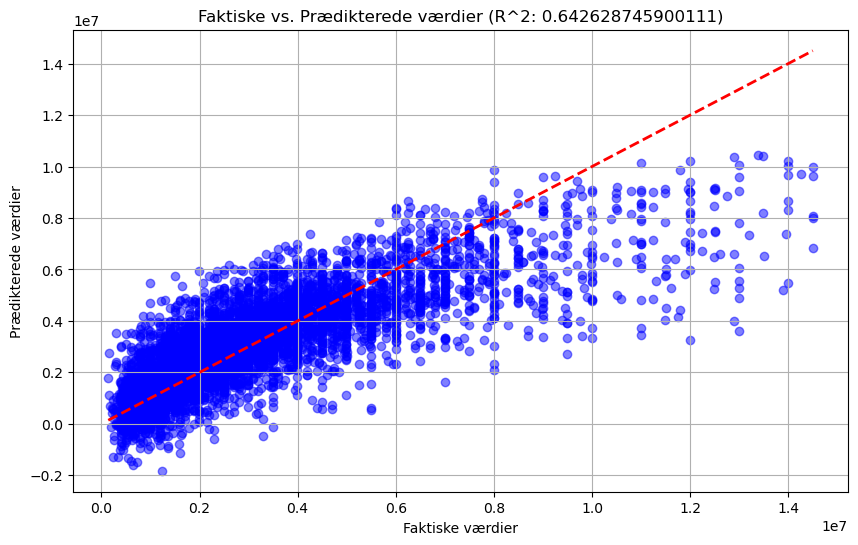

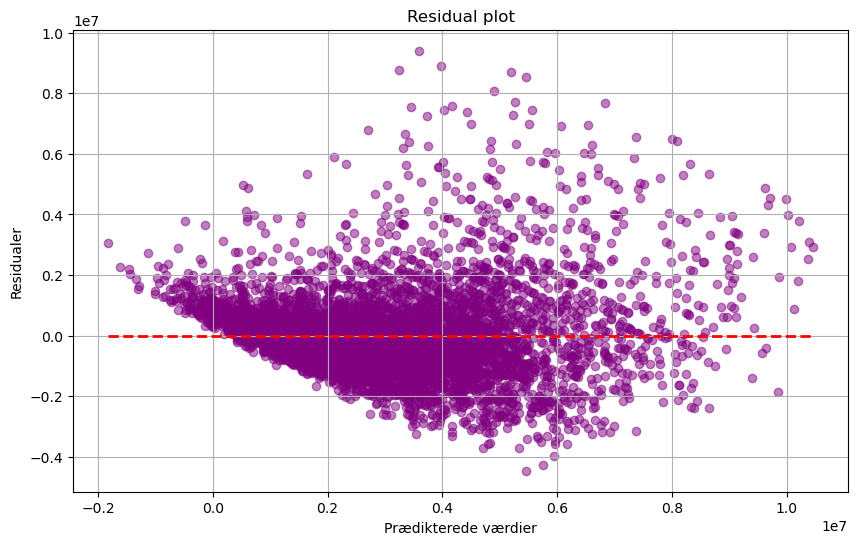

In [267]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_1_cv_5 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de1_cv_5', round(mse(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MAE_de1_cv_5', round(mean_absolute_error(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MAPE_de1_cv_5', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_1_cv_5, y_test)))
print('Ridge_R2_de1_cv_5', r2_score(y_test, y_test_pred_ridge_degree_1_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_1_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_1_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_1_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_1_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_1_cv_5.min(), y_test_pred_ridge_degree_1_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# Ridge, polynomial-features = 2, CV=5

Optimal lambda: 46415.88833612782
Validation MSE: 2149489398584.217


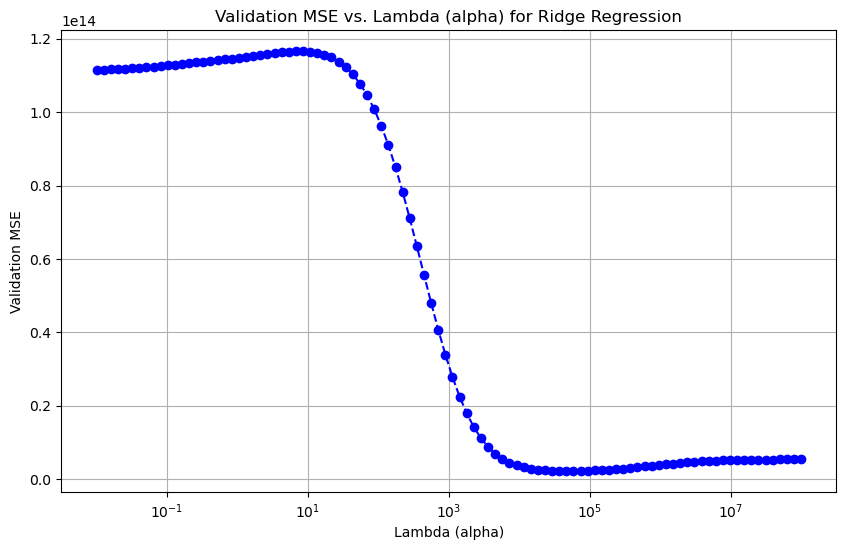

In [269]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                                   StandardScaler(),
                                   Ridge(alpha=lambda_, random_state=42))
        pipe_ridge.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_ridge.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()

In [270]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=46415.88833612782))])

Ridge_MSE_de2_cv_5 1901074465396.73
Ridge_MAE_de2_cv_5 914332.79
Ridge_MAPE_de2_cv_5 0.37
Ridge_RMSE_de2_cv_5 1378794.5696864082
Ridge_R2_de2_cv_5 0.6314693846690749


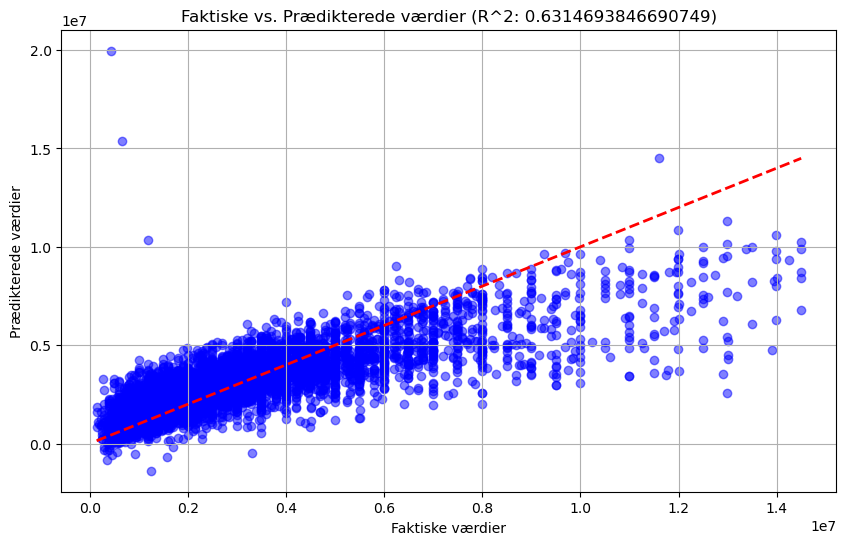

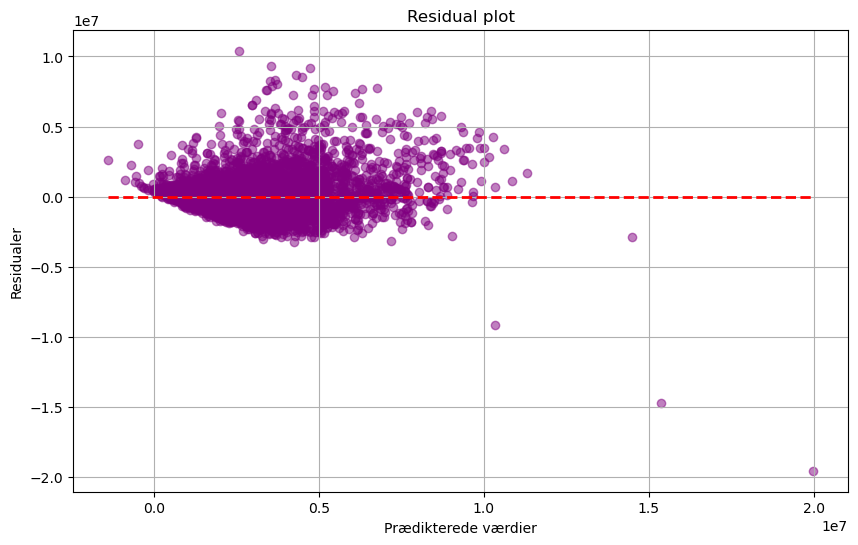

In [271]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_2_cv_5 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de2_cv_5', round(mse(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_MAE_de2_cv_5', round(mean_absolute_error(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_MAPE_de2_cv_5', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_2_cv_5, y_test)))
print('Ridge_R2_de2_cv_5', r2_score(y_test, y_test_pred_ridge_degree_2_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_2_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_2_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_2_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_2_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_2_cv_5.min(), y_test_pred_ridge_degree_2_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# RandomForestRegressor, degree=1, CV=0

In [273]:
from sklearn.ensemble import RandomForestRegressor

pipe_Randomforrest = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           RandomForestRegressor(random_state=42, n_estimators=100))


pipe_Randomforrest.fit(X_dev, y_dev)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

RandomForrest_MSE_de1 812467456537.35
RandomForrest_MAE_de1 570408.39
RandomForrest_MAPE_de1 0.21
RandomForrest_RMSE_de1 901369.7668201181
RandomForrest_R2_de1 0.8425000508164849


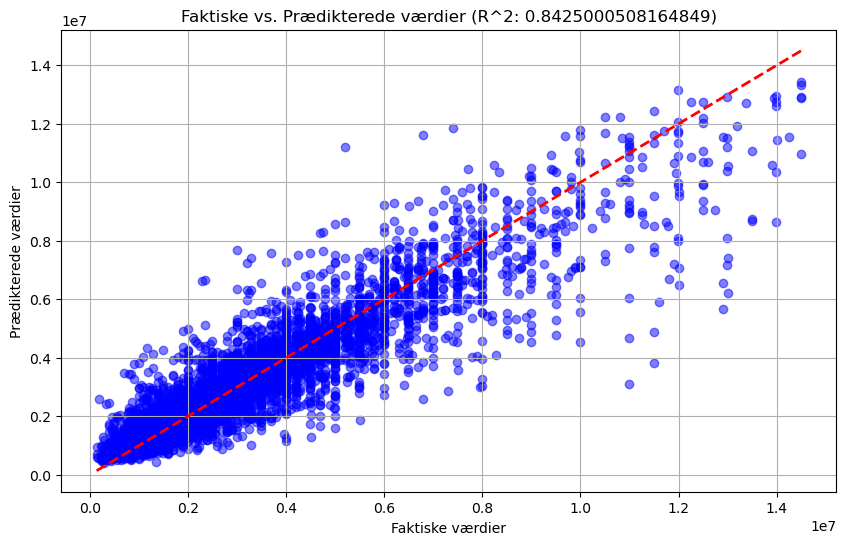

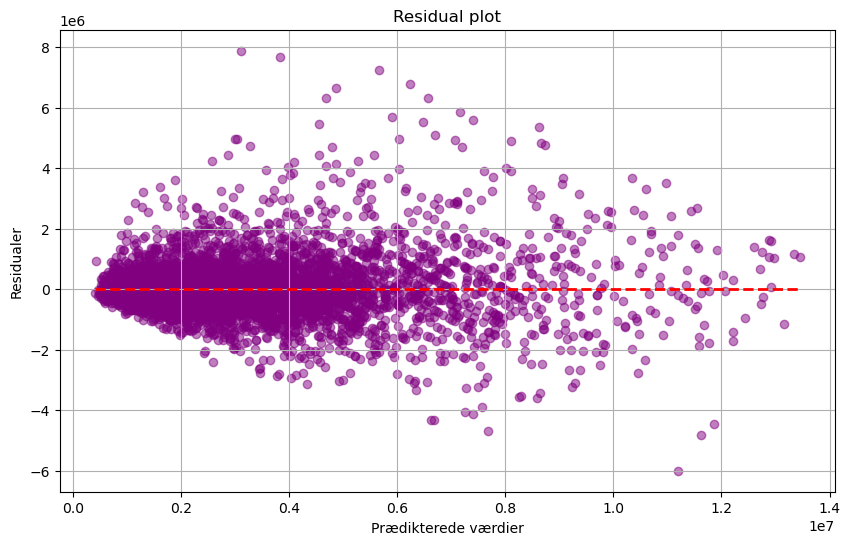

In [274]:
y_test_pred_randomforrest_degree_1 = pipe_Randomforrest.predict(X_test)
print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_1,y_test), 2))
print('RandomForrest_MAE_de1', round(mean_absolute_error(y_test_pred_randomforrest_degree_1, y_test), 2))
print('RandomForrest_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_randomforrest_degree_1, y_test), 2))
print('RandomForrest_RMSE_de1', np.sqrt(mse(y_test_pred_randomforrest_degree_1, y_test)))
print('RandomForrest_R2_de1', r2_score(y_test, y_test_pred_randomforrest_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_randomforrest_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_randomforrest_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_randomforrest_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_randomforrest_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_randomforrest_degree_1.min(), y_test_pred_randomforrest_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()



In [275]:
diff = (y_test_pred_randomforrest_degree_1 - y_test)/y_test

In [276]:
# Determine the observations within the 15% threshold
within_15_percent = np.abs(diff) <= 0.35

# Count the observations
count_within_15_percent = np.sum(within_15_percent)

#
andel = count_within_15_percent/len(diff)
print(andel)

0.8044021230096784


# Randomforrest tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Step 6: Define the pipeline with StandardScaler and RandomForestRegressor
pipeline = make_pipeline(
    StandardScaler(),  # Step for standardization
    RandomForestRegressor(random_state=42)  # Random Forest model
)

# Step 7: Define the hyperparameter grid for RandomizedSearchCV
param_distributions = {
    'randomforestregressor__n_estimators': [50, 100, 500],
    'randomforestregressor__max_features': ['sqrt', 'log2', None],
    'randomforestregressor__max_depth': [10, 30, None],
    'randomforestregressor__min_samples_split': [2, 5],
    'randomforestregressor__min_samples_leaf': [1, 2],
    'randomforestregressor__bootstrap': [True, False]
}

# Step 8: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1,
                                   scoring='neg_mean_squared_error')

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_distributions,
                                     cv=3, verbose=2, n_jobs=-1,
                                   scoring='neg_mean_squared_error')



# Step 9: Fit the model to the training data (X_train, y_train)
random_search.fit(X_dev, y_dev) 
best_params = random_search.best_params_
best_pipeline = random_search.best_estimator_

# Step 10: fit best model on dev set
best_pipeline.fit(X_dev, y_dev)  # Retrain on the full development set (X_dev, y_dev)
y_test_pred = best_pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")

In [ ]:
y_test_pred_randomforrest_tun = best_pipeline.predict(X_test)
print('RandomForrest_MSE_tun', round(mse(y_test_pred_randomforrest_tun,y_test), 2))
print('RandomForrest_MAE_tun', round(mean_absolute_error(y_test_pred_randomforrest_tun, y_test), 2))
print('RandomForrest_MAPE_tun', round(mean_absolute_percentage_error(y_test_pred_randomforrest_tun, y_test), 2))
print('RandomForrest_RMSE_tun', np.sqrt(mse(y_test_pred_randomforrest_tun, y_test)))
print('RandomForrest_R2_tun', r2_score(y_test, y_test_pred_randomforrest_tun))
best_params

# Learning curve (tjek lige at tingene passer)

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_pipeline,
    X=X, #OBS HELE DATASET
    y=y, #OBS HELE DATASET
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes = [500, 1000, 2500, 5000, 7500, 9430, 12500, 15088 ] #RET SLUT PUNKT
)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Calculate mean and standard deviation for training and validation scores
train_mean = -train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = -test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))

# Plot learning curve with shaded error bands
plt.plot(train_sizes, train_mean, 'r-', label='Train', lw=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.2)
plt.plot(train_sizes, test_mean, 'b-', label='Validation', lw=2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='b', alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Sample size")
plt.ylabel("Mean squared error")
plt.yscale('log')  # Logarithmic scale for y-axis
plt.legend(loc="best")

plt.show()


# Conclusion

In [278]:
print('LinReg_MSE_de1', round(mse(y_predict_lr_degree_1,y_test), 2))
print('LinReg_MSE_de2', round(mse(y_predict_lr_degree_2,y_test), 2))
print('Lasso_MSE_de1', round(mse(y_test_pred_lasso_degree_1,y_test), 2))
print('Lasso_MSE_de2', round(mse(y_test_pred_lasso_degree_2,y_test), 2))
print('Lasso_MSE_de1_cv_5', round(mse(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
#print('Lasso_MSE_de2_cv_5', round(mse(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Ridge_MSE_de1', round(mse(y_test_pred_ridge_degree_1,y_test), 2))
print('Ridge_MSE_de2', round(mse(y_test_pred_ridge_degree_2,y_test), 2))
print('Ridge_MSE_de1_cv_5', round(mse(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MSE_de2_cv_5', round(mse(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_1,y_test), 2))
#print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_2,y_test), 2))
print("")

print('LinReg_RMSE_de1', np.sqrt(mse(y_predict_lr_degree_1,y_test)))
print('LinReg_RMSE_de2', np.sqrt(mse(y_predict_lr_degree_2,y_test)))
print('Lasso_RMSE_de1', np.sqrt(mse(y_test_pred_lasso_degree_1,y_test)))
print('Lasso_RMSE_de2', np.sqrt(mse(y_test_pred_lasso_degree_2,y_test)))
print('Lasso_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_1_cv_5, y_test)))
#print('Lasso_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_2_cv_5, y_test)))
print('Ridge_RMSE_de1', np.sqrt(mse(y_test_pred_ridge_degree_1,y_test)))
print('Ridge_RMSE_de2', np.sqrt(mse(y_test_pred_ridge_degree_2,y_test)))
print('Ridge_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_1_cv_5, y_test)))
print('Ridge_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_2_cv_5, y_test)))
print('RandomForrest_RMSE_de1', np.sqrt(mse(y_test_pred_randomforrest_degree_1,y_test)))


table = {
    'OLS 1-deg': {
        'MSE': round(mse(y_predict_lr_degree_1,y_test), 2),
        'RMSE': np.sqrt(mse(y_predict_lr_degree_1,y_test)),
        'MAE': round(mean_absolute_error(y_predict_lr_degree_1,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_predict_lr_degree_1,y_test), 2),
        'R2': r2_score(y_test, y_predict_lr_degree_1)
    },
    'OLS 2-deg': {
        'MSE': round(mse(y_predict_lr_degree_2,y_test), 2),
        'RMSE': np.sqrt(mse(y_predict_lr_degree_2,y_test)),
        'MAE': round(mean_absolute_error(y_predict_lr_degree_2,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_predict_lr_degree_2,y_test), 2),
        'R2': r2_score(y_test, y_predict_lr_degree_2)
    },
    'LASSO 1-deg': {
        'MSE': round(mse(y_test_pred_lasso_degree_1,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_lasso_degree_1,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_lasso_degree_1,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_lasso_degree_1)
    },
    'LASSO 2-deg': {
        'MSE': round(mse(y_test_pred_lasso_degree_2,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_lasso_degree_2,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_lasso_degree_2,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_lasso_degree_2)
    },
     'LASSO 1-deg, CV-5': {
        'MSE': round(mse(y_test_pred_lasso_degree_1_cv_5,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_lasso_degree_1_cv_5,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_lasso_degree_1_cv_5,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1_cv_5,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_lasso_degree_1_cv_5)
     },
    'RIDGE 1-deg': {
        'MSE': round(mse(y_test_pred_ridge_degree_1,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_ridge_degree_1,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_ridge_degree_1,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_ridge_degree_1)
    },
    'RIDGE 2-deg': {
        'MSE': round(mse(y_test_pred_ridge_degree_2,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_ridge_degree_2,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_ridge_degree_2,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_ridge_degree_2)
    },
    'RIDGE 1-deg, CV-5': {
        'MSE': round(mse(y_test_pred_ridge_degree_1_cv_5,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_ridge_degree_1_cv_5,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_ridge_degree_1_cv_5,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1_cv_5,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_ridge_degree_1_cv_5)
    },
    'RIDGE 2-deg, CV-5': {
        'MSE': round(mse(y_test_pred_ridge_degree_2_cv_5,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_ridge_degree_2_cv_5,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_ridge_degree_2_cv_5,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2_cv_5,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_ridge_degree_2_cv_5)
    },
    'RANDOMFORREST 1-deg': {
        'MSE': round(mse(y_test_pred_randomforrest_degree_1,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_randomforrest_degree_1,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_randomforrest_degree_1,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_randomforrest_degree_1,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_randomforrest_degree_1)
    }
}

conclusion_df = pd.DataFrame(table).T

# Function to format numbers based on their magnitude
def format_number(x):
    if abs(x) >= 1e7 or abs(x) < 1e-2:  # More than 7 digits or very small numbers
        return "%.2e" % x
    else:
        return "%.2f" % x

# Apply the custom formatting to all columns in the DataFrame
conclusion_df = conclusion_df.applymap(format_number)

# Now convert the DataFrame to LaTeX
latex_code = conclusion_df.to_latex(index=True, escape=False)



LinReg_MSE_de1 1843391171614.35
LinReg_MSE_de2 5.099202852274224e+31
Lasso_MSE_de1 1843079132767.75
Lasso_MSE_de2 1650136447857.08
Lasso_MSE_de1_cv_5 1842946258977.51
Ridge_MSE_de1 1843853678907.16
Ridge_MSE_de2 1854639894445.48
Ridge_MSE_de1_cv_5 1843508619293.52
Ridge_MSE_de2_cv_5 1901074465396.73
RandomForrest_MSE_de1 812467456537.35

LinReg_RMSE_de1 1357715.4236489888
LinReg_RMSE_de2 7140870291690099.0
Lasso_RMSE_de1 1357600.5055861431
Lasso_RMSE_de2 1284576.3690248567
Lasso_RMSE_de1_cv_5 1357551.567704709
Ridge_RMSE_de1 1357885.7385314698
Ridge_RMSE_de2 1361851.6418631934
Ridge_RMSE_de1_cv_5 1357758.6749100587
Ridge_RMSE_de2_cv_5 1378794.5696864082
RandomForrest_RMSE_de1 901369.7668201181


C:\Users\matli\AppData\Local\Temp\ipykernel_1308\2591163009.py:111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  conclusion_df = conclusion_df.applymap(format_number)


In [279]:

print(latex_code)
conclusion_df

\begin{tabular}{llllll}
\toprule
 & MSE & RMSE & MAE & MAPE & R2 \\
\midrule
OLS 1-deg & 1.84e+12 & 1357715.42 & 933749.34 & 0.81 & 0.64 \\
OLS 2-deg & 5.10e+31 & 7.14e+15 & 2.47e+14 & 0.59 & -9.89e+18 \\
LASSO 1-deg & 1.84e+12 & 1357600.51 & 931900.25 & 1.02 & 0.64 \\
LASSO 2-deg & 1.65e+12 & 1284576.37 & 869368.20 & 0.51 & 0.68 \\
LASSO 1-deg, CV-5 & 1.84e+12 & 1357551.57 & 932168.04 & 1.04 & 0.64 \\
RIDGE 1-deg & 1.84e+12 & 1357885.74 & 933338.15 & 0.91 & 0.64 \\
RIDGE 2-deg & 1.85e+12 & 1361851.64 & 868349.40 & 0.38 & 0.64 \\
RIDGE 1-deg, CV-5 & 1.84e+12 & 1357758.67 & 933607.77 & 2.24 & 0.64 \\
RIDGE 2-deg, CV-5 & 1.90e+12 & 1378794.57 & 914332.79 & 0.37 & 0.63 \\
RANDOMFORREST 1-deg & 8.12e+11 & 901369.77 & 570408.39 & 0.21 & 0.84 \\
\bottomrule
\end{tabular}



,MSE,RMSE,MAE,MAPE,R2
OLS 1-deg,1.84e+12,1357715.42,933749.34,0.81,0.64
OLS 2-deg,5.10e+31,7.14e+15,2.47e+14,0.59,-9.89e+18
LASSO 1-deg,1.84e+12,1357600.51,931900.25,1.02,0.64
LASSO 2-deg,1.65e+12,1284576.37,869368.20,0.51,0.68
"LASSO 1-deg, CV-5",1.84e+12,1357551.57,932168.04,1.04,0.64
RIDGE 1-deg,1.84e+12,1357885.74,933338.15,0.91,0.64
RIDGE 2-deg,1.85e+12,1361851.64,868349.40,0.38,0.64
"RIDGE 1-deg, CV-5",1.84e+12,1357758.67,933607.77,2.24,0.64
"RIDGE 2-deg, CV-5",1.90e+12,1378794.57,914332.79,0.37,0.63
RANDOMFORREST 1-deg,8.12e+11,901369.77,570408.39,0.21,0.84


# Printing list of features

In [281]:
# Example list of column names (replace this with your actual DataFrame column names)
features = df_final.columns.tolist()

# Organize the features into two columns
def organize_into_columns(features):
    mid = len(features) // 2 + len(features) % 2  # Split list roughly in half
    col1 = features[:mid]
    col2 = features[mid:]
    if len(col1) > len(col2):
        col2.append("")  # Ensure both columns have the same length
    return pd.DataFrame({'Column 1': col1, 'Column 2': col2})

df_features = organize_into_columns(features)
#Convert the DataFrame to LaTeX code with a longtable environment
latex_code = df_features.to_latex(index=False, header=True, longtable=False)


print(len(features))
print(features)
print(latex_code)

65
['Price', 'Distance to school', 'Trivsel', 'Kommuneskat', 'Grundskyldspromillen', 'Liggetid', 'm2', 'Grund', 'Ejerudgift', 'Rooms', 'Build', 'Toilets', 'Elevator', 'Altan', 'Terasse', 'Familiernes gennemsnitlige indkomst indkomst', 'm2 parker, sportsanlæg og rekreative omr pr indbygger', 'indbyggertal', 'andel_vestlig_opr', 'andel_ikke_vestlig_opr', 'Gennemsnitlig_pendligafstand', 'Antal_laeger', 'Stationer', 'Karakter', 'anmeldelser pr 1000', 'sigtelser pr 1000', 'AAL', 'AAL_C', 'AAR_C', 'AAR_N', 'AAR_V', 'FRED', 'FRED_C', 'HEL', 'KBH_K', 'KBH_N', 'KBH_S_SV', 'KBH_V', 'KBH_Ø', 'ODE', 'ODE_C', 'Valby', 'Whisky', 'Boligtype_Ejerlejlighed', 'Boligtype_Landejendom', 'Boligtype_Rækkehus', 'Boligtype_Villalejlighed', 'Energy-classification_ A', 'Energy-classification_ A2', 'Energy-classification_ A2010', 'Energy-classification_ A2015', 'Energy-classification_ A2020', 'Energy-classification_ B', 'Energy-classification_ C', 'Energy-classification_ E', 'Energy-classification_ F', 'Energy-cl

In [282]:
print(df_final['Price'].max())
print(df_final['Price'].min())
print(df_final['m2'].max())
print(df_final['m2'].min())


14500000.0
85000.0
332.0
23.0
